In [1]:
## Mount drive from google drive if needed
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
## CD to work directory
import os
% cd /content/drive/MyDrive/Colab Notebooks/tweet_scrape/Twitter_Tweepy_Scrape
# work_dir = input('work directory: ')
# os.chdir(work_dir)
## Check current project directory
% pwd

/content/drive/MyDrive/Colab Notebooks/tweet_scrape/Twitter_Tweepy_Scrape


'/content/drive/MyDrive/Colab Notebooks/tweet_scrape/Twitter_Tweepy_Scrape'

In [3]:
%pip install flair
%pip install gensim
%pip install pyvis

     |████████████████████████████████| 322 kB 11.4 MB/s 
     |████████████████████████████████| 1.2 MB 43.8 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 788 kB 40.1 MB/s 
     |████████████████████████████████| 61 kB 517 kB/s 
     |████████████████████████████████| 48 kB 5.7 MB/s 
     |████████████████████████████████| 981 kB 39.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.7 MB 6.9 MB/s 
     |████████████████████████████████| 3.3 MB 41.8 MB/s 
     |████████████████████████████████| 62 kB 842 kB/s 
     |████████████████████████████████| 895 kB 29.3 MB/s 
     |████████████████████████████████| 596 kB 29.3 MB/s 
     |████████████████████████████████| 3.3 MB 33.8 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=c88dcca5bf26dab70b18e1fe7959a1d37b829d8602297

In [4]:
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import emodict ## This is a emoji dictionary downloaded from github and stored in folders
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
from itertools import combinations
import networkx as nx
from pyvis.network import Network
import seaborn as sn
## Import emoji libraries
EMOTICONS = emodict.EMOTICONS_EMO
UNICODE_EMO = emodict.UNICODE_EMOJI

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# ## Import tweets
# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from oauth2client.client import GoogleCredentials

# gc = gspread.authorize(GoogleCredentials.get_application_default())

# worksheet = gc.open('tweets2').sheet1

# # get_all_values gives a list of rows.
# rows = worksheet.get_all_values()
# print(rows)

# # Convert to a DataFrame and render.
# tweets = pd.DataFrame.from_records(rows)
# new_header = tweets.iloc[0] 
# tweets = tweets[1:] 
# tweets.columns = new_header 

In [5]:
# tweet_filename = input('Tweets Filename: ')
# tweet_filename += '.csv'
# print(tweet_filename)
tweet_filename = 'tweets_biden.csv'

In [6]:
tweets = pd.read_csv(tweet_filename)

In [17]:
tweets

datetime  ...    keyword
0     2021-12-08 02:11:41  ...  joe biden
1     2021-12-08 02:11:40  ...  joe biden
2     2021-12-08 02:11:40  ...  joe biden
3     2021-12-08 02:11:39  ...  joe biden
4     2021-12-08 02:11:39  ...  joe biden
...                   ...  ...        ...
9995  2021-12-08 01:43:30  ...  @joebiden
9996  2021-12-08 01:43:29  ...  @joebiden
9997  2021-12-08 01:43:28  ...  @joebiden
9998  2021-12-08 01:43:26  ...  @joebiden
9999  2021-12-08 01:43:21  ...  @joebiden

[10000 rows x 4 columns]

In [7]:
## Tweet cleaning functions

## Change all tweets to lowercase
def lower_case(tweet):
  return tweet.lower()

## Remove punctuation
def remove_punctuation(tweet):
  PUNCT_TO_REMOVE = string.punctuation+'’'+'「'+'」'
  return tweet.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

## Filter stop words
def filter_stopwords(tweet):
  filtered = ''
  stop_words = stopwords.words('english')
  stop_words.append('im')
  stop_words = set(stop_words)
  word_tokens = word_tokenize(tweet)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  filtered = ' '
  filtered =filtered.join(filtered_sentence)
  return filtered


## Remove unnecessary symbols
def clean(tweet):
  # tweet = re.sub(r'@[A-Za-z0-9]','', tweet) # remove @mention
  # tweet = re.sub(r'@','', tweet)
  # tweet = re.sub(r'#','', tweet) # remove hastag symbol
  tweet = re.sub(r'https?:\/\/\S+','', tweet) # remove hyperlink
  tweet = re.sub(r'rt[\s]+','', tweet) # remove 'RT'
  tweet = remove_punctuation(tweet)
  tweet = filter_stopwords(tweet)



  return tweet




## replace emoji and emoticons to words
# def convert_emoticons(tweet):
#   for emot in EMOTICONS:
#     if emot in tweet:
#       tweet = tweet.replace(emot, EMOTICONS[emot])
#   return tweet

def convert_emoji(tweet):
  for emo in UNICODE_EMO:
    if emo in tweet:
      tweet = tweet.replace(emo, UNICODE_EMO[emo])
    tweet = tweet.lower()
    tweet = tweet.replace(':', '')
    # tweet = tweet.replace('_', ' ')
  return tweet

## Take away the keywords for search in tweets
def take_away_keyword(tweet):
  for k in search_word:
    if k in tweet:
      tweet = tweet.replace(k, '')
  return tweet

## Connect keywords as one word
def connect_keyword(tweet, keyword):
  keyword_connected = keyword.replace(' ', '_')
  if keyword in tweet:
    tweet = tweet.replace(keyword, keyword_connected)
  return tweet
    



In [8]:
def get_hashtag_and_mention(tweet):
  mention = [t for t in str.split(tweet) if '@' in t or '#' in t]
  return mention

mentioned = tweets['tweet'].apply(get_hashtag_and_mention)


## Build Network Graph

In [9]:
comb_lib = {}
for m in range(0, len(mentioned)):
  uniq_comb = [list(set([comb,comb])) for comb in combinations(mentioned[m], 2)]
  for c in uniq_comb:
    if c[0] not in comb_lib.keys():
      comb_lib[c[0]] = 1
    elif c[0] in comb_lib.keys():
      comb_lib[c[0]]+=1

In [10]:
tags_rltship = []
for k,v in comb_lib.items():
  result = [k[0],k[1],v]
  tags_rltship.append(result)

net_rltship = pd.DataFrame(np.array(tags_rltship),columns=['source', 'target', 'counts'])

In [11]:
net_rltship['counts'] = net_rltship['counts'].astype(int)

In [12]:
network_graph = net_rltship.loc[(net_rltship['counts']>10)]

In [13]:
# network_graph.to_csv('net_rltship.csv', index = False)

In [14]:
G = nx.from_pandas_edgelist(network_graph, source = 'source', target = 'target', edge_attr='counts')

In [ ]:
# plt.figure(figsize=(12,12)) 
# nx.draw(G,with_labels = True, font_size = 10, node_size = 7)
# plt.show()

In [18]:
#@title Default title text
net = Network(notebook = True,height='750px', width='100%')
net.from_nx(G)

# net.show('example.html')
net.save_graph('biden_tweet_rltion.html') ## save to working directory

In [20]:
import IPython
IPython.display.HTML(filename='/content/drive/MyDrive/Colab Notebooks/tweet_scrape/Twitter_Tweepy_Scrape/biden_tweet_rltion.html')

In [40]:
keywords = list(set(tweets.keyword))
add_keywords = ['#biden','@joebiden:', '@potus', '"#potus']
[keywords.append(a) for a in add_keywords]
keywords

['#joebiden',
 'joe biden',
 'biden',
 '@joebiden',
 '#potus',
 '#biden',
 '@joebiden:',
 '@potus',
 '"#potus']

In [41]:
from collections import Counter
mentioned= tweets['tweet'].apply(get_hashtag_and_mention)

mentioned = [lower_case(item) for sublist in mentioned.tolist() for item in sublist]
# for i,(k,v) in enumerate(Counter(mentioned_pos).most_common()):
#   if v >= 10:
#     print(k,v)
mentioned_rank = pd.DataFrame(Counter(mentioned).most_common(), columns = ['mentioned', 'counts']).sort_values('counts',ascending=False)
mentioned_rank = mentioned_rank.loc[mentioned_rank['counts']>=20]
mentioned_rank = mentioned_rank.drop(mentioned_rank.loc[ mentioned_rank['mentioned'].isin(keywords)].index)

In [42]:
mentioned_rank.head(10)

mentioned  counts
5      @lopezresists:     210
7             #news":     173
8       @jakeevansga:     165
9      @jojofromjerz:     143
10  @joncoopertweets:     134
12  @occupydemocrats:     113
13       #donaldtrump     102
14       @hhichilema:     101
15               #cnn     100
16       @chuckmodi1:      96

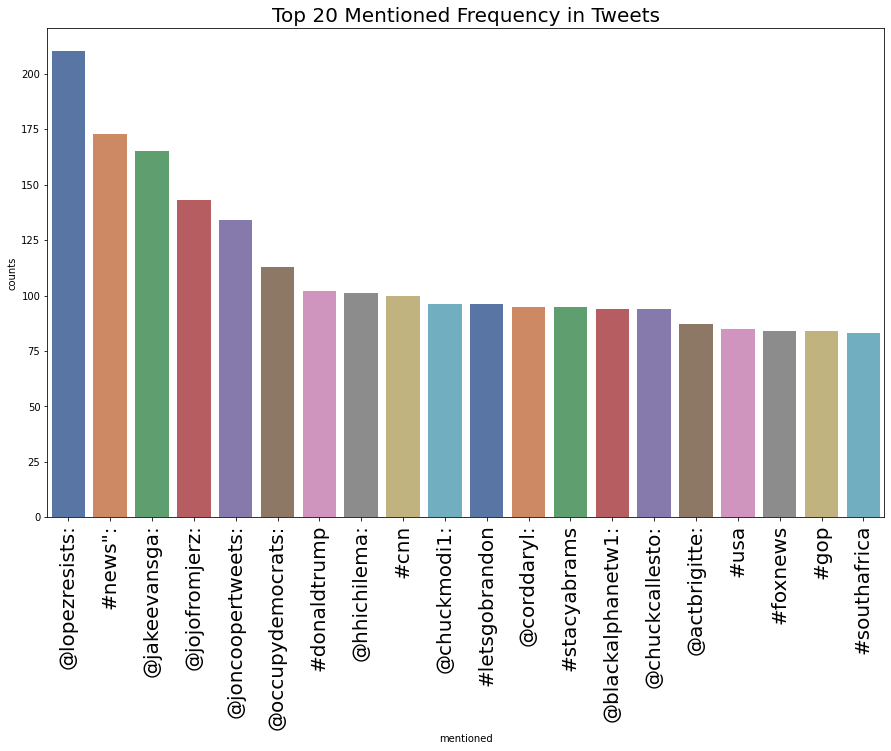

In [43]:
df = mentioned_rank.head(20)
plt.figure(figsize=(15,9))
plt.title("Top 20 Mentioned Frequency in Tweets",size=20)
sn.barplot(x=df['mentioned'], y=df['counts'],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## Load pre-trained sentiment analysis model from Flair

Challenge: This model is trained on IMDB dataset. Can it generalize well on tweets data that are mostly about politics?

In [44]:
all_tweets = tweets.copy()

In [45]:
all_tweets.dropna(subset = ["tweet"], inplace=True)

In [46]:
all_tweets['tweet'] = all_tweets['tweet'].apply(lower_case)
# all_tweets['tweet']  =all_tweets['tweet'].apply(clean)
all_tweets['tweet'] = all_tweets['tweet'].apply(convert_emoji)

# all_tweets['tweet']  = all_tweets.apply(lambda x:connect_keyword(x['tweet'], x['keyword']),axis = 1)

# all_tweets

In [47]:
classifier = TextClassifier.load('en-sentiment')

## Test model
sentence = Sentence('Flair is pretty neat!')
classifier.predict(sentence)
# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2021-12-09 23:24:20,576 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpn2xkjnm3


100%|██████████| 265512723/265512723 [00:08<00:00, 32677299.02B/s]

2021-12-09 23:24:28,803 copying /tmp/tmpn2xkjnm3 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-09 23:24:29,312 removing temp file /tmp/tmpn2xkjnm3
2021-12-09 23:24:29,354 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Sentence above is:  [POSITIVE (0.9997)]


In [48]:
sentences = [Sentence(s) for s in all_tweets['tweet']]

In [49]:
classifier.predict(sentences)


In [50]:
sent = str(sentences[0].labels[0])
num = float(re.findall("\d+\.\d+", sent)[0])
lab = " ".join(re.findall("[a-zA-Z]+", sent))
print(num, lab)

# [float(s) for s in sent.split() if s.isdigit()]

0.7663 NEGATIVE


In [51]:
sent_labels=[]
sent_conf = []
for s in range(0,len(sentences)):
  if sentences[s]:
    sent = str(sentences[s].labels[0])
    sent_conf.append(float(re.findall("\d+\.\d+", sent)[0]))
    sent_labels.append(" ".join(re.findall("[a-zA-Z]+", sent)))

In [52]:
all_tweets['sentiment'] = sent_labels
all_tweets['sentiment_confidence'] =sent_conf


# Summary

In [53]:
count_tweet = all_tweets[['keyword','sentiment','id']].groupby(['keyword','sentiment']).size()
# total_tweets_scraped.groupby(["keyword"]).agg({"total" : "sum"})
# total_tweet = sum(count_tweet)
# cluster_count.char = cluster_count.char * 100 / cluster_sum
percentage = all_tweets.groupby(['keyword','sentiment']).size()/count_tweet.groupby(['keyword']).sum()
result = []
for idx in range(len(count_tweet.index)):
  result.append([count_tweet.index[idx][0],count_tweet.index[idx][1],count_tweet.values[idx],percentage[idx]])
summary = pd.DataFrame(result, columns = ['keyword','sentiment','count','percentage'])
summary

keyword sentiment  count  percentage
0  #joebiden  NEGATIVE   1311      0.6555
1  #joebiden  POSITIVE    689      0.3445
2     #potus  NEGATIVE   1001      0.5005
3     #potus  POSITIVE    999      0.4995
4  @joebiden  NEGATIVE   1080      0.5400
5  @joebiden  POSITIVE    920      0.4600
6      biden  NEGATIVE   1655      0.8275
7      biden  POSITIVE    345      0.1725
8  joe biden  NEGATIVE   1592      0.7960
9  joe biden  POSITIVE    408      0.2040

In [54]:
all_tweets

datetime            id  ... sentiment sentiment_confidence
0     2021-12-08 02:11:41  1.468403e+18  ...  NEGATIVE               0.7663
1     2021-12-08 02:11:40  1.468403e+18  ...  NEGATIVE               0.9100
2     2021-12-08 02:11:40  1.468403e+18  ...  NEGATIVE               0.9953
3     2021-12-08 02:11:39  1.468403e+18  ...  NEGATIVE               0.9642
4     2021-12-08 02:11:39  1.468403e+18  ...  NEGATIVE               0.9999
...                   ...           ...  ...       ...                  ...
9995  2021-12-08 01:43:30  1.468396e+18  ...  POSITIVE               0.6613
9996  2021-12-08 01:43:29  1.468396e+18  ...  NEGATIVE               0.7299
9997  2021-12-08 01:43:28  1.468396e+18  ...  POSITIVE               0.8710
9998  2021-12-08 01:43:26  1.468396e+18  ...  POSITIVE               0.6598
9999  2021-12-08 01:43:21  1.468396e+18  ...  NEGATIVE               0.9999

[10000 rows x 6 columns]

In [55]:
from datetime import datetime
all_tweets['datetime'] = all_tweets.apply(lambda x:connect_keyword(x['datetime'], '%Y-%m-%d %H:%M%S'),axis = 1)


In [56]:
def get_date(datetime_str):
  date = datetime_str.split(' ')
  date = date[0]
  return date

def get_hour(datetime_str):
  hour = all_tweets['datetime'].iloc[0].split(' ')[1].split(':')[0]
  return int(hour)

def label_pos_sent(sentiment):
  if sentiment == 'POSITIVE':
    label = 1
  else:
    label = 0
  return label

In [57]:
all_tweets['date'] = all_tweets['datetime'].apply(get_date)

In [58]:
all_tweets['hour'] = all_tweets['datetime'].apply(get_hour)

In [59]:
all_tweets['positive'] = all_tweets['sentiment'].apply(label_pos_sent)

In [60]:
date_sentiment = all_tweets.groupby(['date'])['positive'].mean()

In [61]:
date_sentiment = pd.DataFrame(date_sentiment)
# date_sentiment['example_pos'] = 


## Plot sentiment flow and hand select tweet examples

In [65]:
set(all_tweets['date'])

{'2021-12-03',
 '2021-12-04',
 '2021-12-05',
 '2021-12-06',
 '2021-12-07',
 '2021-12-08'}

In [166]:
all_tweets['tweet'].loc[(all_tweets['sentiment'] == 'NEGATIVE')&(all_tweets['date'] == '2021-12-08')].sample(n=10)

960     the world is becoming more dangerous under joe...
278     joe biden? that's the biggest idiot that i kno...
2773    rt @occupydemocrats breaking new poll shows th...
4090    this "man" couldn't win against other men, so ...
53      rt @judicialwatch over 300,000 signatures on o...
2830    rt @patriottakes marjorie taylor greene posted...
9384    rt @joncoopertweets outrageous a federal court...
6014    "#potus news biden’s supreme court commission ...
9099    @totallyfedup @dxnyfishy @joebiden hello ameri...
1788    rt @joncoopertweets joe biden loves our milita...
Name: tweet, dtype: object

In [167]:
# all_tweets['tweet'].loc[7843][0:80]
all_tweets['tweet'].loc[960]

'the world is becoming more dangerous under joe biden https//t.co/jjmbr3vzgb via @nypost'

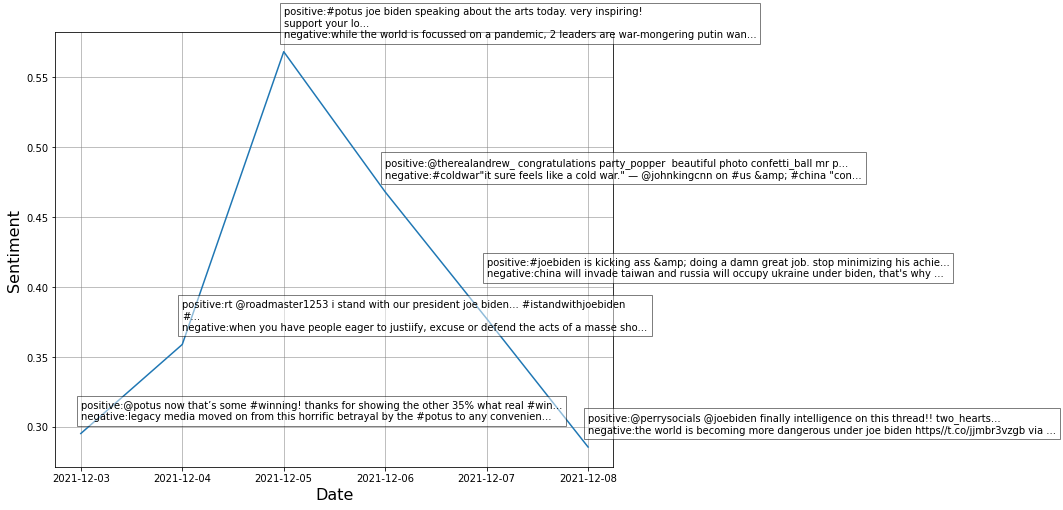

In [169]:
plt.figure(figsize = (10,8))
plt.plot(date_sentiment.index, date_sentiment.values)

textstr_12_03 = '\n'.join((
    r'positive:'+all_tweets['tweet'].loc[7843][0:80]+'...',
    r'negative:'+all_tweets['tweet'].loc[7841][0:80]+'...'))
textstr_12_04 = '\n'.join((
    r'positive:'+all_tweets['tweet'].loc[7569][0:80]+'...',
    r'negative:'+all_tweets['tweet'].loc[7717][0:80]+'...'))
textstr_12_05 = '\n'.join((
    r'positive:'+all_tweets['tweet'].loc[7247][0:80]+'...',
    r'negative:'+all_tweets['tweet'].loc[7443][0:80]+'...'))
textstr_12_06 = '\n'.join((
    r'positive:'+all_tweets['tweet'].loc[5859][0:80]+'...',
    r'negative:'+all_tweets['tweet'].loc[5517][0:80]+'...'))
textstr_12_07 = '\n'.join((
    r'positive:'+all_tweets['tweet'].loc[4417][0:80]+'...',
    r'negative:'+all_tweets['tweet'].loc[4814][0:80]+'...'))
textstr_12_08 = '\n'.join((
    r'positive:'+all_tweets['tweet'].loc[8459][0:80]+'...',
    r'negative:'+all_tweets['tweet'].loc[960][0:80]+'...'))

plt.text(x = all_tweets['date'].loc[7843], y=date_sentiment.loc[all_tweets['date'].loc[7843]]+0.01, s = textstr_12_03, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)
plt.text(x = all_tweets['date'].loc[7569], y=date_sentiment.loc[all_tweets['date'].loc[7569]]+0.01, s = textstr_12_04, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)
plt.text(x = all_tweets['date'].loc[7452], y=date_sentiment.loc[all_tweets['date'].loc[7452]]+0.01, s = textstr_12_05, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)
plt.text(x = all_tweets['date'].loc[5859], y=date_sentiment.loc[all_tweets['date'].loc[5859]]+0.01, s = textstr_12_06, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)
plt.text(x = all_tweets['date'].loc[4417], y=date_sentiment.loc[all_tweets['date'].loc[4417]]+0.03, s = textstr_12_07, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)
plt.text(x = all_tweets['date'].loc[8459], y=date_sentiment.loc[all_tweets['date'].loc[8459]]+0.01, s = textstr_12_08, bbox=dict(facecolor='white', alpha=0.5), fontsize = 10)



plt.xlabel('Date', fontsize = 16)
plt.ylabel('Sentiment', fontsize = 16)
plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

# Gensim Phrases Model

In [170]:
%pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 44.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [171]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases #, ENGLISH_CONNECTOR_WORDS
from gensim.models import Word2Vec

In [172]:
## Split tweets into word in arrays
all_tweets['tweet'] = all_tweets['tweet'].apply(clean)
sentence_stream = [sent.split(" ") for sent in all_tweets['tweet']]

In [173]:
## Train Phrases model
phrases = Phrases(sentence_stream, min_count=1, threshold=1)

In [174]:
all_p= [phrases[sentence_stream[m]] for m in range(0,len(sentence_stream))]



/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  start_token, in_between = word, []  # treat word as both end of a phrase AND beginning of another


In [175]:
all_tweets['word_token'] = all_p


In [176]:
all_tweets_pos = [sent.split(" ") for sent in all_tweets['tweet'].loc[all_tweets['sentiment'] == 'POSITIVE']]
all_tweets_neg = [sent.split(" ") for sent in all_tweets['tweet'].loc[all_tweets['sentiment'] == 'NEGATIVE']]

## Print word embedding relationship

In [177]:
## train word2vec model
modelwv_pos = Word2Vec(phrases[all_tweets_pos], min_count=1)
modelwv_neg = Word2Vec(phrases[all_tweets_neg], min_count=1)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  start_token, in_between = word, []  # treat word as both end of a phrase AND beginning of another


In [178]:
print(len(modelwv_pos.wv.vocab),len(modelwv_neg.wv.vocab))
# for index, word in enumerate(modelwv.wv):
#     if index == 10:
#         break
#     print(f"word #{index}/{len(wv.index_to_key)} is {word}")

8420 15800


In [183]:
relative_biden_pos = modelwv_pos.most_similar(positive=['joe_biden'], topn=100)
relative_biden_neg = modelwv_neg.most_similar(positive=['joe_biden'], topn=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [184]:
tags_rltship_pos = []
tags_rltship_neg = []

for w in relative_biden_pos:
  result = ['joe_biden', w[0],w[1]]
  tags_rltship_pos.append(result)

for w in relative_biden_neg:
  result = ['joe_biden', w[0],w[1]]
  tags_rltship_neg.append(result)

net_rltship_pos = pd.DataFrame(np.array(tags_rltship_pos),columns=['source', 'target', 'counts'])
net_rltship_neg = pd.DataFrame(np.array(tags_rltship_neg),columns=['source', 'target', 'counts'])

In [185]:
X = [w[0] for w in relative_biden_pos]
word_vec = {}
for v in list(X):
  word_vec[v] = modelwv_pos[v]
df=pd.DataFrame(word_vec).transpose()
print(df.shape)


(100, 100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [186]:
from sklearn.manifold import TSNE

In [187]:
%pip install -U scikit-learn

In [188]:
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', random_state=42).fit_transform(df.values)


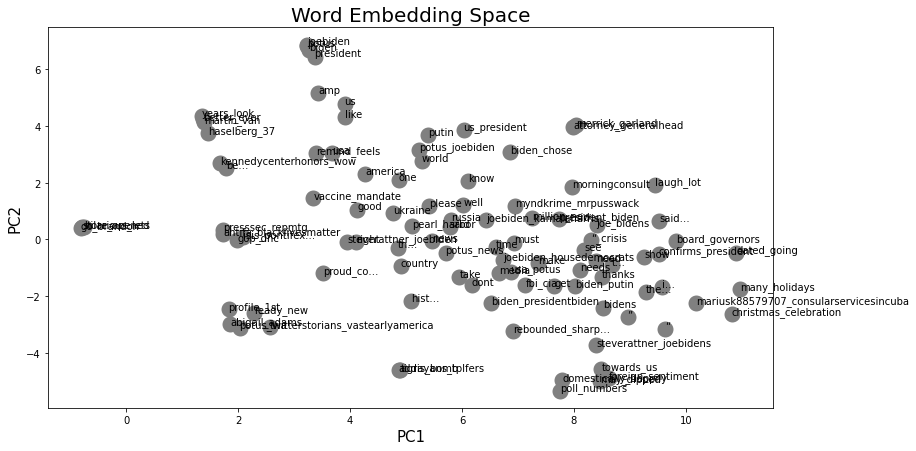

In [189]:
plt.figure(figsize=(13,7))
plt.scatter(X_embedded[:,0], X_embedded[:,1],linewidths=10,color='grey')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
# vocab=list(modelwv_pos.wv.vocab)
for i, word in enumerate(X):
  plt.annotate(word,xy=(X_embedded[i,0],X_embedded[i,1]))

# LDA Topic Model

In [190]:
%pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from gensim.models.ldamodel import LdaModel

     |████████████████████████████████| 1.7 MB 13.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 39.2 MB/s 
     |████████████████████████████████| 15.7 MB 36.6 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=5ff53d371992fb2c3397beb076d8c64e831ff0ec2930029281c2120e9ea8e73d
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take i

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa


In [191]:
stopword = stopwords.words('english')
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [192]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"], save_model = False, filename = ''):
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    if save_model == True:
        file = open(filename+'.txt', "w")
        for element in texts_out:
            file.write(element + "\n")
        file.close()
    return (texts_out)


# lemmatized_texts = dtaby_data['token_tweet'].apply(lemmatization)
# print(lemmatized_texts[0][0:90])

In [193]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

# data_words = dtaby_data['token_tweet'].apply(gen_words)

# print(data_words)

In [194]:
def concatinate_all_word(data_frame):
  new_word = []
  for w in range(len(data_frame['word_token'])):
    for n in range(len(data_frame['word_token'].iloc[w])):
      new_word.append(data_frame['word_token'].iloc[w][n])
  return new_word





In [195]:
def get_phrases(lem_word):
  lem_phrase = []
  for n in lem_word:
    if '_' in n:
      lem_phrase.append(n)
  return lem_phrase

In [196]:
def ida_param(dat_word):
  id2word = corpora.Dictionary(dat_word)
  corpus = []
  for text in dat_word:
      new = id2word.doc2bow(text)
      corpus.append(new)
  return corpus, id2word

In [197]:
def create_lda_model_gensim(id_dict, corpus, num_topics):
    lda_model = LdaModel(corpus=corpus,
                         id2word=id_dict,
                         num_topics=num_topics, 
                         random_state=100,
                         chunksize=100,
                         passes=10)
    return lda_model

In [198]:
all_tweets

datetime  ...                                         word_token
0     2021-12-08 02:11:41  ...  [fluttershyirl_liberal, little_pony, wokeity_g...
1     2021-12-08 02:11:40  ...  [phoenix_pauses, covid19_vaccine, mandate_city...
2     2021-12-08 02:11:40  ...  [chuckmodi1_civil, asset_forfeiture, legalized...
3     2021-12-08 02:11:39  ...  [sentedcruz_barack, obama_joe, biden_inexplica...
4     2021-12-08 02:11:39  ...  [ahmalcolm_reminder, one_year, ago_joe, biden_...
...                   ...  ...                                                ...
9995  2021-12-08 01:43:30  ...  [joebiden, suppoyour_local, unions, join, get_...
9996  2021-12-08 01:43:29  ...  [steverattner_joebiden, morningconsult, impact...
9997  2021-12-08 01:43:28  ...  [joebiden_thanks, american_rescue, plan_weve, ...
9998  2021-12-08 01:43:26  ...  [ashupasu_govmikedewine, ltgovhusted_thank, jo...
9999  2021-12-08 01:43:21  ...                           [joebiden, one_believes]

[10000 rows x 10 columns]

### Train LDA model

In [199]:
word_pos = all_tweets.loc[ (all_tweets['sentiment'] == 'POSITIVE')]
word_neg = all_tweets.loc[(all_tweets['sentiment'] == 'NEGATIVE')]
new_word_pos = concatinate_all_word(word_pos)
new_word_neg = concatinate_all_word(word_neg)
new_word_pos =[w for w in new_word_pos if not w.lower() in stopword]
new_word_neg = [w for w in new_word_neg if not w.lower() in stopword]
lem_phrase_pos = lemmatization(new_word_pos)
lem_phrase_neg = lemmatization(new_word_neg)
lem_phrase_pos = get_phrases(lem_phrase_pos)
lem_phrase_neg = get_phrases(lem_phrase_neg)
# lem_phrase_pos = get_phrases(new_word_pos)
# lem_phrase_neg = get_phrases(new_word_neg)
dat_word_pos= gen_words(lem_phrase_pos)
dat_word_neg= gen_words(lem_phrase_neg)
corpus_pos, id2word_pos = ida_param(dat_word_pos)
corpus_neg, id2word_neg = ida_param(dat_word_neg)

### Figure out the number of topic

In [200]:
def plot_coherence(id_dict, corpus, random_state = 100, min_topic_num = 2, max_topic_num = 10):
    num_topics_range = range(min_topic_num, max_topic_num+1)
    coherences = []
    for num_topics in num_topics_range:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id_dict,
                                           num_topics=num_topics, 
                                           random_state=random_state,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
        coherence_model_lda = CoherenceModel(model=lda_model, corpus = corpus, dictionary=id_dict, coherence='u_mass')
        coherences.append(coherence_model_lda.get_coherence())
    plt.plot(num_topics_range, coherences, color='blue', marker='o', markersize=5)
    plt.title('Coherence as a function of number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.xlim(min_topic_num-1, max_topic_num+1)
    plt.xticks(np.arange(min_topic_num, max_topic_num, step=1))
    plt.grid()
    plt.show()

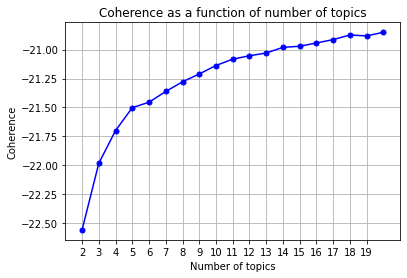

In [201]:
plot_coherence(id2word_pos, corpus_pos, random_state = 100, max_topic_num=20)

Chossing 9 topics for positive tweets here because after that, coherance does not increase. 

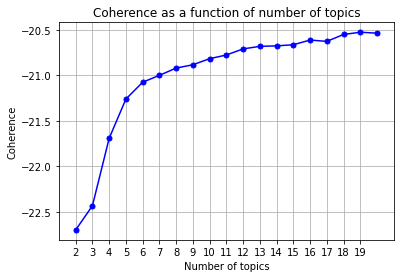

In [202]:
plot_coherence(id2word_neg, corpus_neg, random_state = 100, max_topic_num=20)

Chossing 11 topics for positive tweets here because after that, coherance does not increase a lot. 

In [203]:

lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=6, #number of topic
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
lda_model_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
                                           id2word=id2word_neg,
                                           num_topics=6, #number of topic
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [204]:
print(lda_model_pos.print_topics())
print(lda_model_neg.print_topics())

[(0, '0.097*"us_president" + 0.071*"suppoyour_local" + 0.055*"devinator" + 0.055*"bear_fully" + 0.049*"joebiden_vp" + 0.035*"us_world" + 0.034*"born_president" + 0.021*"said_great" + 0.021*"cherinet" + 0.016*"great_real"'), (1, '0.197*"blackalphanetw" + 0.097*"joebiden_stand" + 0.092*"ohio_president" + 0.074*"kjno" + 0.042*"hilarious_let" + 0.033*"jobs_coming" + 0.029*"gun_violence" + 0.026*"trump_lion" + 0.016*"joebiden_sound" + 0.016*"walking_dead"'), (2, '0.121*"amp_co" + 0.075*"covid" + 0.055*"lost_" + 0.045*"like_tree" + 0.039*"supply_chain" + 0.031*"vaccine_mandate" + 0.024*"marylandguy" + 0.024*"countries_happy" + 0.024*"amalik" + 0.022*"eu_congress"'), (3, '0.810*"created_nearly" + 0.029*"stavridisj_cnn" + 0.028*"record_pace" + 0.010*"nice" + 0.010*"workers_nice" + 0.006*"responsibleame" + 0.004*"tribal_member" + 0.003*"ados_movement" + 0.003*"build_back" + 0.003*"love_family"'), (4, '0.103*"russo" + 0.100*"years_look" + 0.057*"receives_weapon" + 0.051*"mr_president" + 0.042*"f

In [205]:
import pyLDAvis.gensim_models as pgm
%pip install --upgrade pandas==1.2

     |████████████████████████████████| 9.9 MB 8.5 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.


In [206]:
pyLDAvis.enable_notebook()
vis = pgm.prepare(lda_model_pos, corpus_pos, id2word_pos, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.293506 -0.327899       1        1  34.633153
1     -0.133712  0.259755       2        1  18.640596
4      0.146658 -0.181500       3        1  14.419651
2      0.158478  0.209814       4        1  13.223868
0      0.212715  0.010051       5        1  10.885945
5     -0.090633  0.029779       6        1   8.196786, topic_info=                Term        Freq       Total Category  logprob  loglift
217   created_nearly  324.000000  324.000000  Default  30.0000  30.0000
80    blackalphanetw   43.000000   43.000000  Default  29.0000  29.0000
161           amp_co   19.000000   19.000000  Default  28.0000  28.0000
226   joebiden_stand   21.000000   21.000000  Default  27.0000  27.0000
232            russo   18.000000   18.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
112   ideology_hatre    0.620823    1.561695   Topic6  -5.0254   1.5789
109   mining_bitcoin    0.620823    1.561695   Topic6  -5.0254   1.5789
116  country_luckily    0.620823    1.561695   Topic6  -5.0254   1.5789
115         cost_get    0.620820    1.561694   Topic6  -5.0254   1.5789
150   feel_concerned    0.581737    1.523934   Topic6  -5.0904   1.5384

[210 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
148       6  0.708218  access_hundred
135       4  0.498293  admitted_union
73        1  0.447351   ados_movement
156       4  0.810824       alneamyyy
231       6  0.860209   also_discusse
...     ...       ...             ...
210       1  0.479662      would_also
242       2  0.741912       year_year
140       3  0.973628      years_look
168       4  0.562511          yemen_
119       5  0.597408          𝑜𝑢𝑡_𝑜𝑓

[176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1, 6])

In [207]:
pyLDAvis.enable_notebook()
vis = pgm.prepare(lda_model_neg, corpus_neg, id2word_neg, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111436  0.275945       1        1  23.045940
5     -0.113074 -0.366543       2        1  17.584854
0     -0.344007 -0.047246       3        1  16.190095
4     -0.195635  0.281707       4        1  14.692099
3      0.204272 -0.209913       5        1  14.611317
1      0.337009  0.066049       6        1  13.875694, topic_info=                Term        Freq       Total Category  logprob  loglift
176    georgia_halte  191.000000  191.000000  Default  30.0000  30.0000
496     press_highly  161.000000  161.000000  Default  29.0000  29.0000
487     cost_sharing  121.000000  121.000000  Default  28.0000  28.0000
497        doubt_goe  115.000000  115.000000  Default  27.0000  27.0000
495    take_question  114.000000  114.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
369    someone_treat    2.630444    3.339520   Topic6  -5.0722   1.7364
422     large_amount    2.541631    3.236583   Topic6  -5.1065   1.7333
291     leave_robust    2.357562    3.037633   Topic6  -5.1817   1.7216
117  president_unite    2.304697    2.980251   Topic6  -5.2044   1.7180
411     olympics_due    2.347460    3.064821   Topic6  -5.1860   1.7084

[211 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
504       2  0.872925        abaygedey
433       3  0.716629     admin_toward
286       4  0.710501          akbarth
540       1  0.933249           amalik
483       6  0.950919  american_family
...     ...       ...              ...
518       1  0.865097        wont_even
123       3  0.461318      world_stage
99        3  0.468760  worst_president
464       6  0.931945       wtf_matter
368       2  0.914759      yall_really

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 5, 4, 2])

# Wordcloud

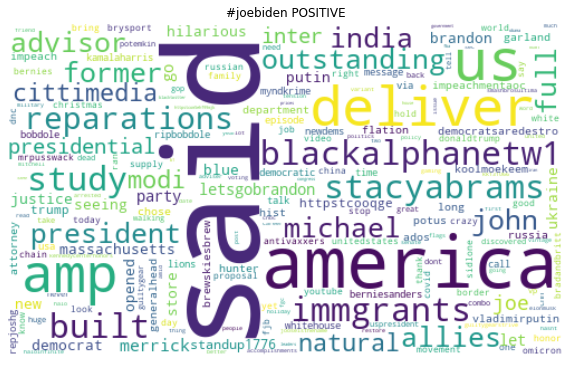

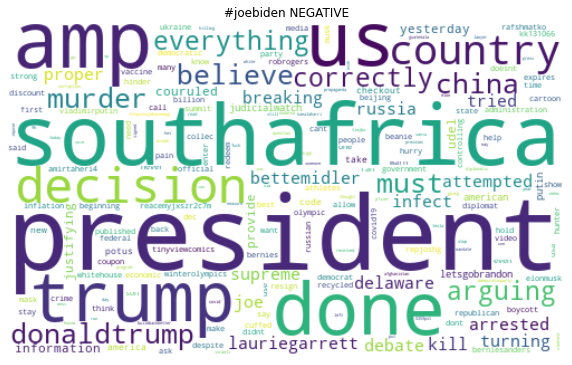

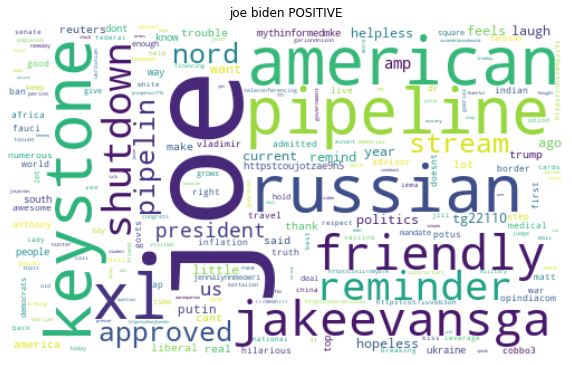

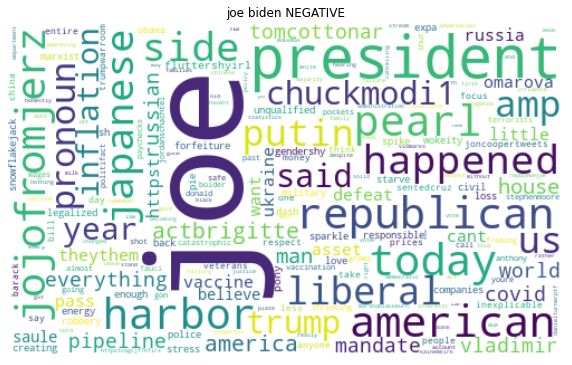

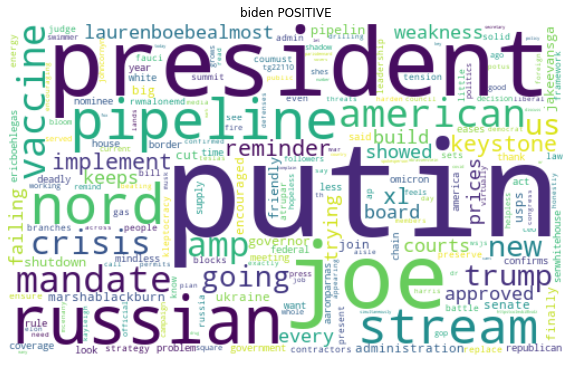

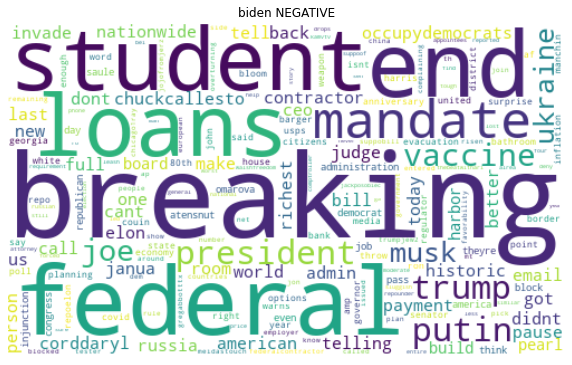

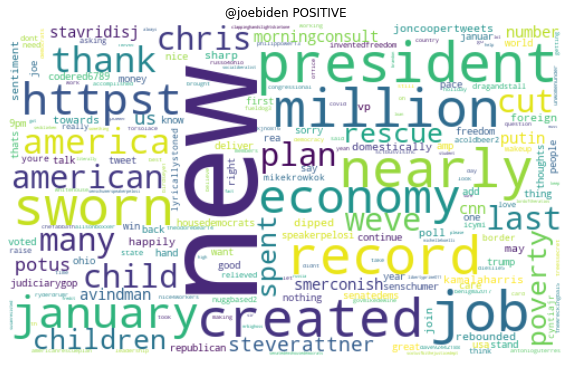

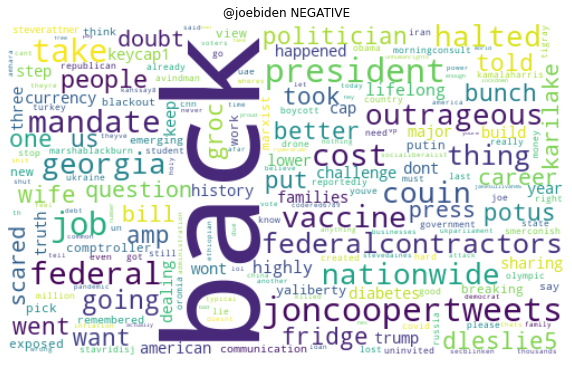

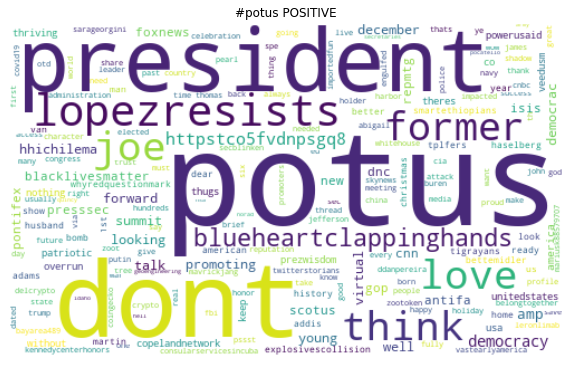

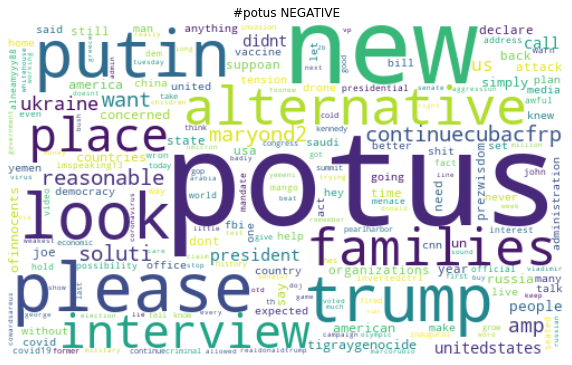

In [209]:
## Plot word cloud
sent = ['POSITIVE', 'NEGATIVE']

for k in set(all_tweets['keyword']):
  for s in sent:
    if not all_tweets['tweet'].loc[(all_tweets['keyword']==k) & (all_tweets['sentiment']==s)].empty:
      allwords = ' '.join([tweet for tweet in all_tweets['tweet'].loc[(all_tweets['keyword']==k) & (all_tweets['sentiment']==s)] ])
      allwords = re.sub('joebiden', '', allwords)
      allwords = re.sub('biden', '', allwords)
      wordCloud = WordCloud(background_color='white', width = 500, height = 300, random_state = 1234, max_font_size = 119,collocations=False).generate(allwords)
      plt.figure(figsize=(10, 8))
      plt.imshow(wordCloud, interpolation = 'bilinear')
      plt.axis('off')
      title_name = k+' '+s
      plt.title(title_name)
      plt.show()

In [225]:
def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 



text = all_tweets.tweet.iloc[0]

dict = {
  "joe biden" : "",
  "potus" : "",
  "biden" : "",
  "joebiden" : "",
  "amp":"",
  "president":"",
  "new":"",
  "http":""
} 

print(all_tweets.tweet.iloc[0])
print(multiple_replace(dict, text))

fluttershyirl liberal little pony wokeity gendershy joe biden sparkle theythem dash pronoun pie snowflakejack spike like sh…
fluttershyirl liberal little pony wokeity gendershy  sparkle theythem dash pronoun pie snowflakejack spike like sh…


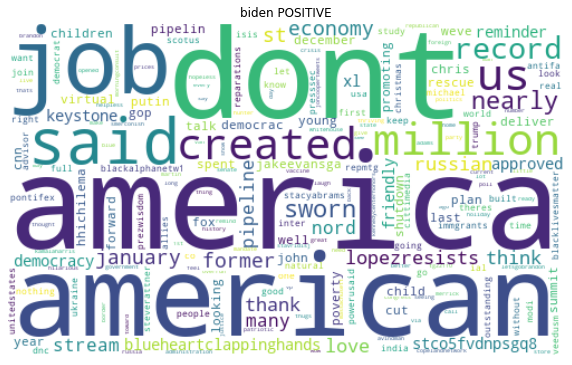

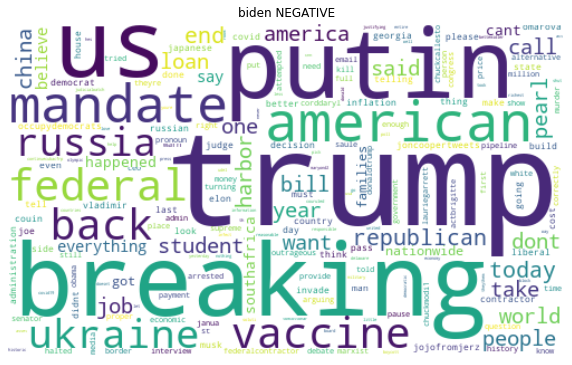

In [226]:
## Plot word cloud
sent = ['POSITIVE', 'NEGATIVE']


for s in sent:
  # if not all_tweets['tweet'].loc[(all_tweets['keyword']==k) & (all_tweets['sentiment']==s)].empty:
    allwords = ' '.join([tweet for tweet in all_tweets['tweet'].loc[(all_tweets['sentiment']==s)] ])
    # allwords = re.sub('joebiden', '', allwords)
    # allwords = re.sub('biden', '', allwords)
    allwords = multiple_replace(dict, allwords)
    wordCloud = WordCloud(background_color='white', width = 500, height = 300, random_state = 1234, max_font_size = 119,collocations=False).generate(allwords)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordCloud, interpolation = 'bilinear')
    plt.axis('off')
    title_name = 'biden '+s
    plt.title(title_name)
    plt.show()

# Plot hashtags and mentioned by sentiment

In [227]:
tweets_hashtag = tweets.copy()
tweets_hashtag = tweets_hashtag.iloc[all_tweets.index]
tweets_hashtag['sentiment'] = all_tweets['sentiment']

In [228]:
tweets_hashtag['mentioned'] = tweets_hashtag['tweet'].apply(get_hashtag_and_mention)


In [229]:
pos_mentioned = []
neg_mentioned = []
for t in range(0,len(tweets_hashtag['mentioned'])):
# for t in range(0,3):
  if len(tweets_hashtag['mentioned'].iloc[t])>0:
    if tweets_hashtag['sentiment'].iloc[t] == 'POSITIVE':
      pos_mentioned += tweets_hashtag['mentioned'].iloc[t]
    elif tweets_hashtag['sentiment'].iloc[t] == 'NEGATIVE':
      neg_mentioned += tweets_hashtag['mentioned'].iloc[t]

In [230]:
pos_mentioned = [each_string.lower() for each_string in pos_mentioned]
neg_mentioned = [each_string.lower() for each_string in neg_mentioned]

In [231]:
pos_mentioned = [remove_punctuation(each_string) for each_string in pos_mentioned]
neg_mentioned = [remove_punctuation(each_string) for each_string in neg_mentioned]

## Summary

In [232]:
count_word = [len(pos_mentioned), len(neg_mentioned)]
percentage = [len(pos_mentioned) / (len(pos_mentioned)+len(neg_mentioned)), len(neg_mentioned)/ (len(pos_mentioned)+len(neg_mentioned))]
result = {'sentiment':['pos', 'neg'], 'count': count_word, 'percentage': percentage}
summary = pd.DataFrame(result)
print('summary of mentioned')
print(summary)

summary of mentioned
  sentiment  count  percentage
0       pos   9052    0.428193
1       neg  12088    0.571807


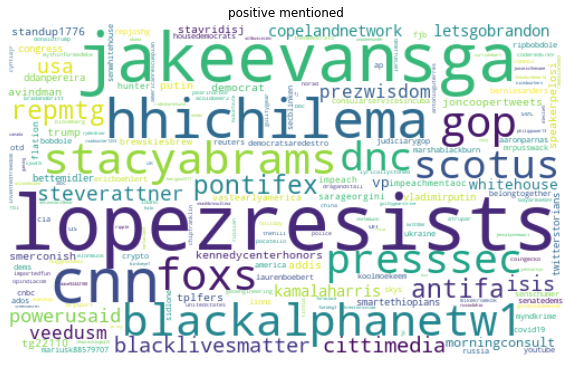

In [236]:
allwords = ' '.join(pos_mentioned)
allwords = multiple_replace(dict, allwords)
wordCloud = WordCloud(background_color='white', width = 500, height = 300, random_state = 1234, max_font_size = 119,collocations=False).generate(allwords)
plt.figure(figsize=(10, 8))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
title_name = 'positive mentioned'
plt.title(title_name)
plt.show()

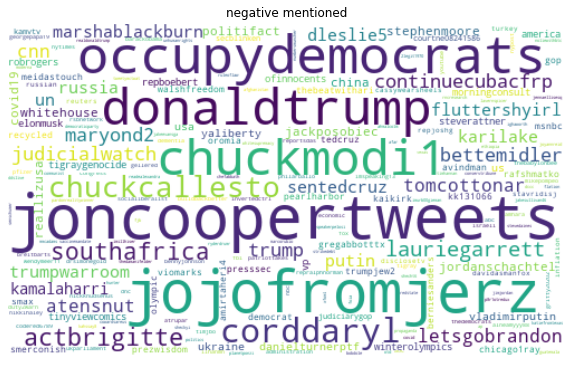

In [237]:
allwords = ' '.join(neg_mentioned)
allwords = multiple_replace(dict, allwords)
wordCloud = WordCloud(background_color='white', width = 500, height = 300, random_state = 1234, max_font_size = 119,collocations=False).generate(allwords)
plt.figure(figsize=(10, 8))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
title_name = 'negative mentioned'
plt.title(title_name)
plt.show()

In [259]:
def takeout_keywords(ignore_words, counter_object):
  for word in list(counter_object):
      if word in ignore_words:
          del counter_object[word]
  return counter_object

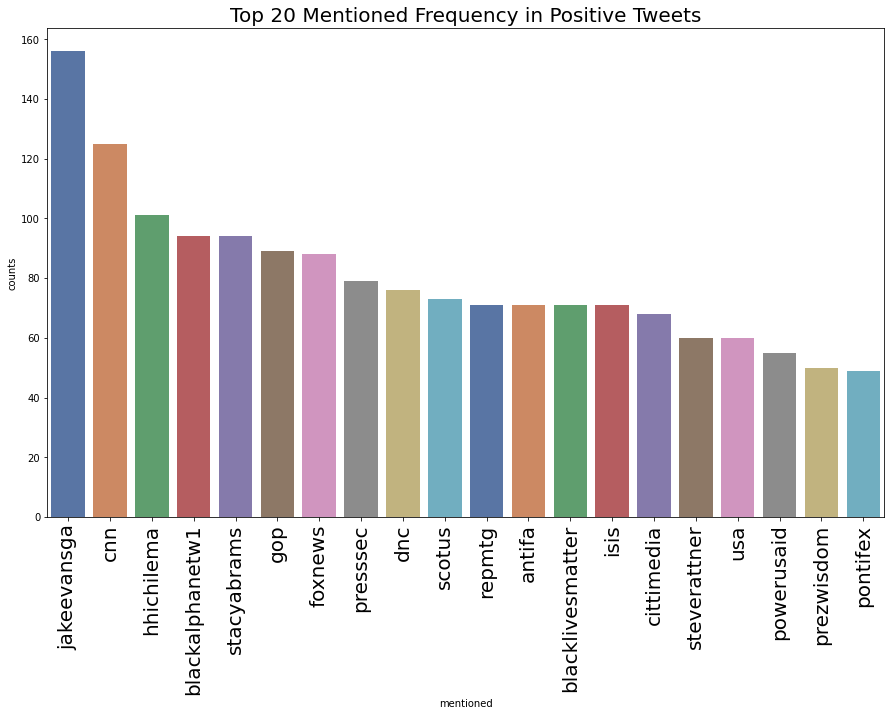

In [260]:
from collections import Counter
pos_count = Counter(pos_mentioned)
ignore = ['joebiden', 'potus']
pos_count = takeout_keywords(ignore, pos_count)

pos_count = pos_count.most_common()
df = pd.DataFrame(pos_count[1:21], columns=['mentioned', 'counts'])
plt.figure(figsize=(15,9))
plt.title("Top 20 Mentioned Frequency in Positive Tweets",size=20)
sn.barplot(x=df['mentioned'], y=df['counts'],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()



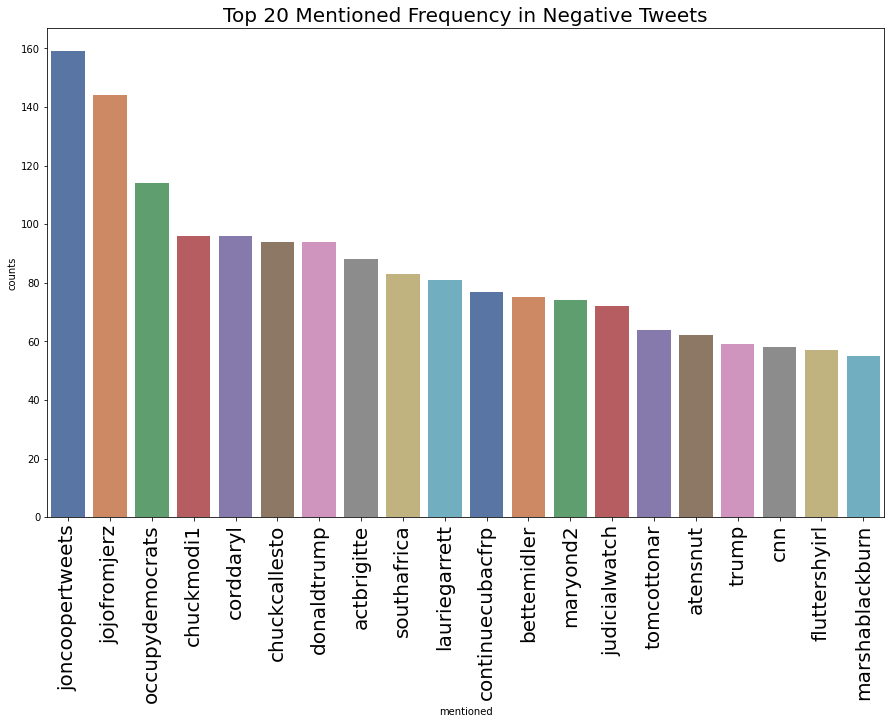

In [263]:
neg_count = Counter(neg_mentioned)
ignore = ['joebiden', 'potus', 'joebidens','biden']
neg_count = takeout_keywords(ignore, neg_count)

neg_count = neg_count.most_common()

df = pd.DataFrame(neg_count[1:21], columns=['mentioned', 'counts'])
plt.figure(figsize=(15,9))
plt.title("Top 20 Mentioned Frequency in Negative Tweets",size=20)
sn.barplot(x=df['mentioned'], y=df['counts'],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()